<a href="https://colab.research.google.com/github/rick1270/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions_Clayton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=598.4488951059684, mobile=False), User(purchased=False, time_on_site=335.3759114874762, mobile=False), User(purchased=False, time_on_site=94.75784020357519, mobile=False), User(purchased=False, time_on_site=20.933649634647757, mobile=True), User(purchased=True, time_on_site=125.47436253918653, mobile=True), User(purchased=False, time_on_site=76.79754419404014, mobile=True), User(purchased=False, time_on_site=172.38919659920043, mobile=True), User(purchased=False, time_on_site=523.508598238219, mobile=False), User(purchased=False, time_on_site=411.5226547031318, mobile=False), User(purchased=False, time_on_site=56.922434619606435, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,598.448895,False
1,False,335.375911,False
2,False,94.757840,False
3,False,20.933650,True
4,True,125.474363,True


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.080934990419045,5.700104095659285,6.507795905995909,6.584918398508073,6.706849919995432,6.7893747853660615,7.016521880410094,7.995240412289737,8.647173163179737,9.102359771184043,...,569.7919585171135,579.6251835105171,581.6331067783276,582.946605945013,583.1032294063173,586.1699779300353,589.2589179092909,595.4770865331709,595.601485519259,598.4488951059684
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,1,1,1,1,0,1,1,...,1,0,1,0,1,0,0,1,1,1
True,1,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,1,1,0,0,0


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.488, 123.755]","(123.755, 242.428]","(242.428, 361.102]","(361.102, 479.775]","(479.775, 598.449]"
purchased,,,,,
False,265,310,163,49,52
True,62,57,27,5,10


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.488, 123.755]","(123.755, 242.428]","(242.428, 361.102]","(361.102, 479.775]","(479.775, 598.449]"
purchased,,,,,
False,0.810398,0.844687,0.857895,0.907407,0.83871
True,0.189602,0.155313,0.142105,0.092593,0.16129


In [8]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.896,0.82
True,0.104,0.18


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [10]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers:

read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, skipfooter=0, skip_footer=0, doublequote=True, delim_whitespace=False, as_recarray=None, compact_ints=None, use_unsigned=None, low_memory=True, buffer_lines=None, memory_map=False, float_precision=None)


In [44]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
persons_URL = 'https://raw.githubusercontent.com/rick1270/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv'
person_data = pd.read_csv(persons_URL)
person_data.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [39]:
person_data.describe()

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


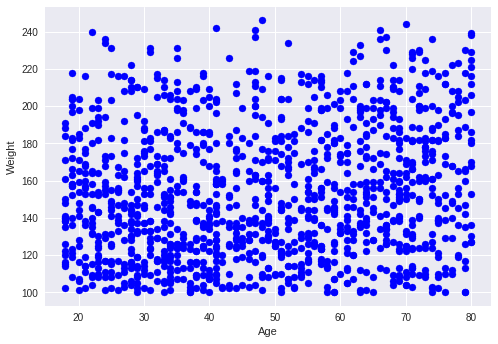

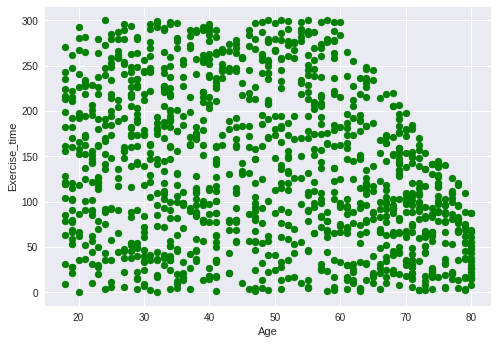

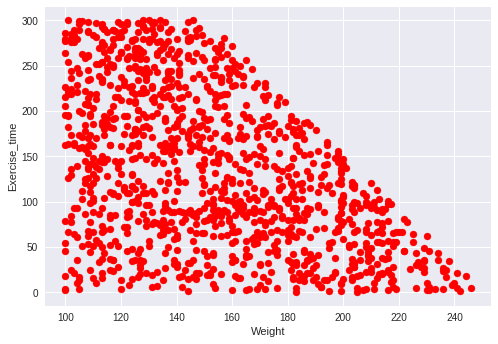

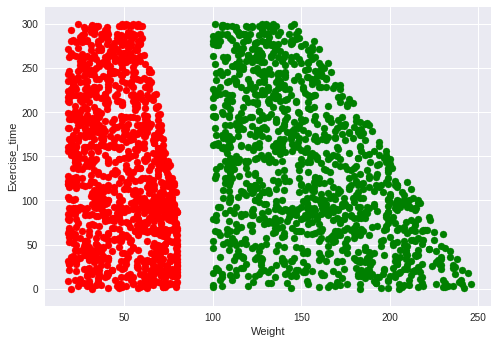

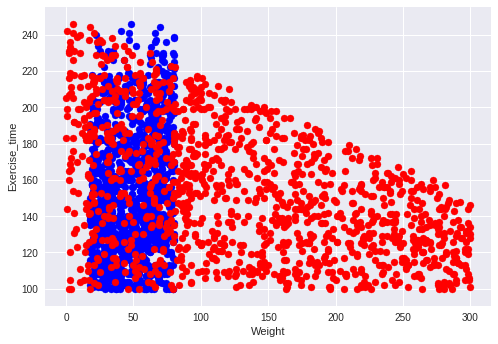

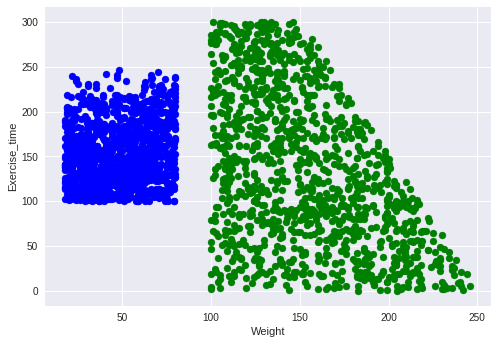

In [67]:
#@title Default title text
fig, ax1 = plt.subplots()
ax1.set_axisbelow(True)
ax1.set_xlabel('Age')
ax1.set_ylabel('Weight')
plt.scatter(person_data ['age'], person_data['weight'], color = 'blue')
fig, ax2 = plt.subplots()
ax2.set_axisbelow(True)
ax2.set_xlabel('Age')
ax2.set_ylabel('Exercise_time')
plt.scatter(person_data ['age'], person_data['exercise_time'], color = 'green')
fig, ax3 = plt.subplots()
ax3.set_axisbelow(True)
ax3.set_xlabel('Weight')
ax3.set_ylabel('Exercise_time')
plt.scatter(person_data ['weight'], person_data['exercise_time'], color ='red')
fig, ax3 = plt.subplots()
ax3.set_axisbelow(True)
ax3.set_xlabel('Weight')
ax3.set_ylabel('Exercise_time')
plt.scatter(person_data ['weight'], person_data['exercise_time'], color = 'green')
plt.scatter(person_data ['age'], person_data['exercise_time'], color = 'red')
fig, ax4 = plt.subplots()
ax4.set_axisbelow(True)
ax4.set_xlabel('Weight')
ax4.set_ylabel('Exercise_time')
plt.scatter(person_data ['age'], person_data["weight"], color = 'blue')
plt.scatter(person_data ['exercise_time'], person_data['weight'], color = 'red')
fig, ax5 = plt.subplots()
ax5.set_axisbelow(True)
ax5.set_xlabel('Weight')
ax5.set_ylabel('Exercise_time')
plt.scatter(person_data ['age'], person_data['weight'], color = 'blue')
plt.scatter(person_data ['weight'], person_data['exercise_time'], color = 'green')




### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
All of them are Int
2.  What are the relationships between the variables?
 Exercise time/age and Exercise time / weight appear similar  
3.  Which relationships are "real", and which spurious?
Weight and exercise time appear real... the others do not


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)